# Classify chest x-rays as w/ or w/o abnormalities

In [35]:
#@title Version notes
version_notes = "EffNet, 1024 resolution, threshold 0.8" #@param {type:"string"}

In [1]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/Colab\ Notebooks/kaggle
    from setup_colab import setup_colab_for_kaggle, INPUT_FOLDER, OUTPUT_FOLDER, WORK_FOLDER, dump_dataset_metadata
    setup_colab_for_kaggle(check_env=False, local_working=True)
except:
    print("Not in Colab")

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content of Drive Kaggle data dir (/content/drive/MyDrive/kaggle): ['/content/drive/MyDrive/kaggle/input', '/content/drive/MyDrive/kaggle/working', '/content/drive/MyDrive/kaggle/.ipynb_checkpoints', '/content/drive/MyDrive/kaggle/output']
Content of Kaggle data dir (/kaggle): ['/kaggle/working', '/kaggle/output', '/kaggle/input']
Content of Kaggle data subdir (/kaggle/input): ['/kaggle/input/cassava-model', '/kaggle/input/cassava-leaf-disease-classification', '/kaggle/input/googlebitemperedloss', '/kaggle/input/vbdyolo', '/kaggle/input/.ipynb_checkpoints', '/kaggle/input/vinbigdata', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection', '/kaggle/input/vinbigdata-chest-xray-original-png']
Content of Kaggle data subdir (/kaggle/output): ['/kaggle/output/vbdyolo_out_1_300epochs', '/

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 8.3MB/s 


In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras.applications import EfficientNetB3 as EfficientNetBX
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm

INPUT_FOLDER_DATA = INPUT_FOLDER / "vinbigdata-chest-xray-abnormalities-detection"
OUTPUT_FOLDER_CUR = OUTPUT_FOLDER / "vbdbinary"
INPUT_FOLDER_PNG = WORK_FOLDER / "vinbigdata"

2.4.1


Reset the GPU (free any used up memory)

In [6]:
from numba import cuda
cuda.get_current_device().reset()

In [7]:
!nvidia-smi

Wed Mar 17 15:32:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
gpu = tf.config.list_physical_devices("GPU")[0]
tf.config.experimental.set_memory_growth(gpu, False)

## Prepare data for binary classification

In [9]:
%cd {WORK_FOLDER}
!kaggle datasets download xhlulu/vinbigdata-chest-xray-resized-png-1024x1024 -p {INPUT_FOLDER_PNG} --unzip

/kaggle/working
100% 7.34G/7.35G [01:23<00:00, 19.9MB/s]
100% 7.35G/7.35G [01:23<00:00, 94.8MB/s]


In [10]:
train_df = pd.read_csv(INPUT_FOLDER_DATA / "train.csv")
train_df = train_df[["image_id", "class_name"]].groupby("image_id").agg(lambda x: "normal" if (x.to_numpy() == "No finding").all() else "abnormal").reset_index()
train_df["image_file_name"] = train_df["image_id"].astype(str) + ".png"
display(train_df.sample(5))
print(train_df.shape)
display(train_df["class_name"].value_counts())

,image_id,class_name,image_file_name
5511,5e6f63376103299f2251a23a696459cd,normal,5e6f63376103299f2251a23a696459cd.png
7102,799e7a57e2c036421744c9fbb9ae40ca,normal,799e7a57e2c036421744c9fbb9ae40ca.png
1918,21ae8b5e6e2a0647a7bb648c15241feb,normal,21ae8b5e6e2a0647a7bb648c15241feb.png
3273,37d3b4cee875cb8f44bde09c70455e0d,normal,37d3b4cee875cb8f44bde09c70455e0d.png
2120,2550db13e3e4174fb2980fbc965c4856,normal,2550db13e3e4174fb2980fbc965c4856.png


(15000, 3)


normal      10606
abnormal     4394
Name: class_name, dtype: int64

## Setup image loading and augmentation

In [11]:
IMAGE_SIZE = (1024, 1024)
BATCH_SIZE = 8

In [12]:
generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.1,
    data_format="channels_last"
)

# Use color_mode=rgb to have the images converted from grayscale.
train_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="training"
)

valid_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

Found 13500 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


Which class is in fact a "positive"

In [13]:
train_dataset.class_indices

{'abnormal': 0, 'normal': 1}

## Configure the model

In [14]:
input = Input(IMAGE_SIZE + (3,))

backbone = EfficientNetBX(include_top=False, weights="imagenet", input_tensor=input, pooling="avg")

backbone.trainable = False
# Unfreeze only some of layers.
for layer in backbone.layers:
    # BatchNormalization should be always kept frozen.
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model = Sequential([
    backbone,
    Dropout(0.2),
    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

print(model.summary())

43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 12,362,544
Trainable params: 1,576,961
Non-

In [15]:
optimizer = Adam(learning_rate=1e-3)
loss = BinaryCrossentropy(label_smoothing=0.01)
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="prec"),
    Recall(name="rec"),
    AUC(name="pr_auc", curve="PR")
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the model

In [14]:
OUTPUT_FOLDER_CUR.mkdir(parents=True, exist_ok=True)

model_checkpoint = ModelCheckpoint(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

results = model.fit(
    train_dataset,
    epochs=30,
    # steps_per_epoch=10,
    shuffle=False, # Already shuffled by datagen
    callbacks=[model_checkpoint, early_stopping, reduce_lr_on_plateau, tqdm_callback],
    validation_data=valid_dataset,
    # validation_steps=10,
    verbose=1
)

model.save(OUTPUT_FOLDER_CUR / "chest_xray_binary.h5")

Epoch 1/30
Epoch 1/30


1688/1688 [==============================] - 4505s 3s/step - loss: 0.5663 - accuracy: 0.7550 - prec: 0.8167 - rec: 0.8434 - pr_auc: 0.8861 - val_loss: 0.3711 - val_accuracy: 0.8347 - val_prec: 0.8962 - val_rec: 0.8657 - val_pr_auc: 0.9551

Epoch 2/30
Epoch 2/30


1688/1688 [==============================] - 4381s 3s/step - loss: 0.4258 - accuracy: 0.8100 - prec: 0.8413 - rec: 0.9018 - pr_auc: 0.9261 - val_loss: 0.3298 - val_accuracy: 0.8573 - val_prec: 0.8557 - val_rec: 0.9593 - val_pr_auc: 0.9689

Epoch 3/30
Epoch 3/30


1688/1688 [==============================] - 4300s 3s/step - loss: 0.4111 - accuracy: 0.8182 - prec: 0.8462 - rec: 0.9067 - pr_auc: 0.9332 - val_loss: 0.3210 - val_accuracy: 0.8680 - val_prec: 0.8643 - val_rec: 0.9640 - val_pr_auc: 0.9729

Epoch 4/30
Epoch 4/30


1688/1688 [==============================] - 4340s 3s/step - loss: 0.4048 - accuracy: 0.8263 - prec: 0.8521 - rec: 0.9121 - pr_auc: 0.9350 - val_loss: 0.3458 - val_accuracy: 0.8460 - val_prec: 0.8273 - val_rec: 0.9877 - val_pr_auc: 0.9733

Epoch 5/30
Epoch 5/30


1688/1688 [==============================] - 4410s 3s/step - loss: 0.4012 - accuracy: 0.8247 - prec: 0.8504 - rec: 0.9123 - pr_auc: 0.9379 - val_loss: 0.3565 - val_accuracy: 0.8553 - val_prec: 0.9516 - val_rec: 0.8373 - val_pr_auc: 0.9728

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6/30
Epoch 6/30


1688/1688 [==============================] - 4326s 3s/step - loss: 0.3762 - accuracy: 0.8417 - prec: 0.8728 - rec: 0.9090 - pr_auc: 0.9450 - val_loss: 0.2810 - val_accuracy: 0.8887 - val_prec: 0.8931 - val_rec: 0.9565 - val_pr_auc: 0.9761

Epoch 7/30
Epoch 7/30


1688/1688 [==============================] - 4336s 3s/step - loss: 0.3736 - accuracy: 0.8397 - prec: 0.8687 - rec: 0.9106 - pr_auc: 0.9473 - val_loss: 0.2781 - val_accuracy: 0.8880 - val_prec: 0.8923 - val_rec: 0.9565 - val_pr_auc: 0.9767

Epoch 8/30
Epoch 8/30


1688/1688 [==============================] - 4485s 3s/step - loss: 0.3642 - accuracy: 0.8484 - prec: 0.8718 - rec: 0.9198 - pr_auc: 0.9485 - val_loss: 0.2754 - val_accuracy: 0.8913 - val_prec: 0.8887 - val_rec: 0.9669 - val_pr_auc: 0.9795

Epoch 9/30
Epoch 9/30


1688/1688 [==============================] - 4546s 3s/step - loss: 0.3626 - accuracy: 0.8486 - prec: 0.8705 - rec: 0.9234 - pr_auc: 0.9499 - val_loss: 0.2695 - val_accuracy: 0.8980 - val_prec: 0.9072 - val_rec: 0.9527 - val_pr_auc: 0.9778

Epoch 10/30
Epoch 10/30


1688/1688 [==============================] - 4495s 3s/step - loss: 0.3549 - accuracy: 0.8551 - prec: 0.8769 - rec: 0.9259 - pr_auc: 0.9525 - val_loss: 0.2601 - val_accuracy: 0.9013 - val_prec: 0.9047 - val_rec: 0.9612 - val_pr_auc: 0.9799

Epoch 11/30
Epoch 11/30


1688/1688 [==============================] - 4503s 3s/step - loss: 0.3482 - accuracy: 0.8574 - prec: 0.8836 - rec: 0.9188 - pr_auc: 0.9551 - val_loss: 0.2767 - val_accuracy: 0.8940 - val_prec: 0.8898 - val_rec: 0.9697 - val_pr_auc: 0.9795

Epoch 12/30
Epoch 12/30


1688/1688 [==============================] - 4432s 3s/step - loss: 0.3626 - accuracy: 0.8482 - prec: 0.8718 - rec: 0.9189 - pr_auc: 0.9484 - val_loss: 0.2679 - val_accuracy: 0.8960 - val_prec: 0.8983 - val_rec: 0.9612 - val_pr_auc: 0.9797

Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13/30
Epoch 13/30


1688/1688 [==============================] - 4505s 3s/step - loss: 0.3627 - accuracy: 0.8467 - prec: 0.8633 - rec: 0.9286 - pr_auc: 0.9509 - val_loss: 0.2640 - val_accuracy: 0.9020 - val_prec: 0.9041 - val_rec: 0.9631 - val_pr_auc: 0.9793
Restoring model weights from the end of the best epoch.

Epoch 00013: early stopping



## Learning curves and model performance

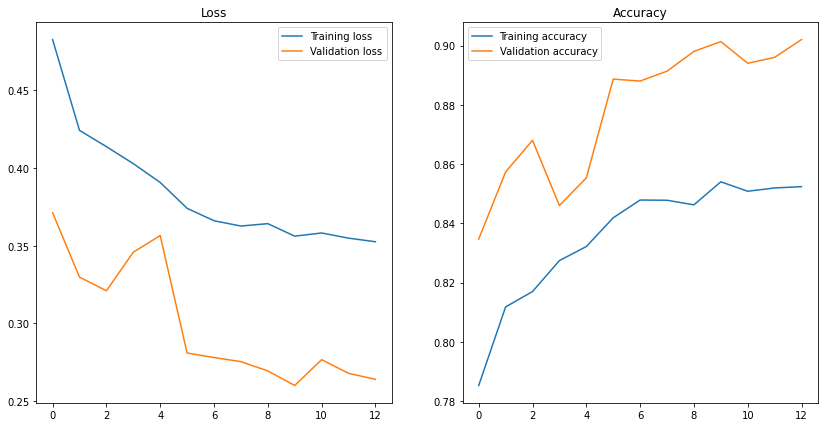

In [15]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(x=results.epoch, y=results.history["loss"], ax=ax[0], label="Training loss")
sns.lineplot(x=results.epoch, y=results.history["val_loss"], ax=ax[0], label="Validation loss")
ax[0].set_title("Loss")

sns.lineplot(x=results.epoch, y=results.history["accuracy"], ax=ax[1], label="Training accuracy")
sns.lineplot(x=results.epoch, y=results.history["val_accuracy"], ax=ax[1], label="Validation accuracy")
_ = ax[1].set_title("Accuracy")

## Evaluate
Get predictions for validation set and print classification report

In [31]:
THRESHOLD = 0.8

In [17]:
model.load_weights(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5")

In [19]:
[val_loss, val_accuracy, val_prec, val_rec, val_pr_auc] = model.evaluate(valid_dataset, callbacks=[tfa.callbacks.TQDMProgressBar()], verbose=1)

188/188 [==============================] - 460s 2s/step - loss: 0.2599 - accuracy: 0.8993 - prec: 0.8995 - rec: 0.9650 - pr_auc: 0.9811



In [20]:
valid_pred_probabilities = model.predict(
    valid_dataset,
    callbacks=[tfa.callbacks.TQDMProgressBar()]
)
valid_predictions = (valid_pred_probabilities > THRESHOLD).reshape(-1).astype(np.int32)

In [33]:
from sklearn.metrics import classification_report

print(classification_report(valid_dataset.classes, valid_predictions, target_names=list(train_dataset.class_indices.keys()),))

              precision    recall  f1-score   support

    abnormal       0.72      0.92      0.81       443
      normal       0.96      0.85      0.90      1057

    accuracy                           0.87      1500
   macro avg       0.84      0.89      0.86      1500
weighted avg       0.89      0.87      0.88      1500



Text(0.5, 1.0, 'Precision-Recall Curve')

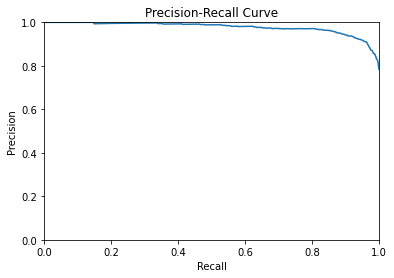

In [34]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(valid_dataset.classes, valid_pred_probabilities)

ax = sns.lineplot(x=recall, y=precision)
ax.set(xlabel="Recall", ylabel="Precision")
ax.axis([0, 1, 0, 1])
ax.set_title("Precision-Recall Curve")

## Predict

In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_id_to_name = {v: k for k, v in train_dataset.class_indices.items()}
images = list((INPUT_FOLDER_PNG / "test").iterdir())
results = pd.DataFrame(columns=["image_id", "class_name"])

for image_file in tqdm(images, total=len(images)):
    image = load_img(image_file, target_size=IMAGE_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    pred_prob = model.predict(image)
    pred = int((pred_prob > THRESHOLD).squeeze())

    results = results.append({"image_id": image_file.stem, "class_name": class_id_to_name[pred]}, ignore_index=True)

results.to_csv(OUTPUT_FOLDER_CUR / "prediction.csv", index=False)
results.sample(5)

,image_id,class_name
2658,ac30fba4f3b56ce91061a996da50ca33,abnormal
2962,85ffcfa2cb02025abd57e2ed21ec4aa2,abnormal
1054,7e406876f2125c3be2c61f32965384c4,normal
431,d870570354a036a5532ade79579261b9,normal
1170,a0e47101a18af84ab9cfc2d9669226cf,normal


## Store output to Kaggle

In [39]:
dump_dataset_metadata("witalia", "vbdbinary", OUTPUT_FOLDER_CUR)

# !kaggle datasets create -p {OUTPUT_FOLDER_CUR} -r zip
!kaggle datasets version -m "{version_notes}" -p {OUTPUT_FOLDER_CUR} -r zip

Starting upload for file chest_xray_binary_best.h5
100% 59.8M/59.8M [00:03<00:00, 17.3MB/s]
Upload successful: chest_xray_binary_best.h5 (60MB)
Starting upload for file chest_xray_binary.h5
100% 59.8M/59.8M [00:06<00:00, 9.45MB/s]
Upload successful: chest_xray_binary.h5 (60MB)
Starting upload for file prediction.csv
100% 119k/119k [00:02<00:00, 52.6kB/s]
Upload successful: prediction.csv (119KB)
Dataset version is being created. Please check progress at https://www.kaggle.com/witalia/vbdbinary
